## Importing needed libraries

In [1]:
#wget shell script taken from johnsnowlabs tutorials -> used to get spark to work on Google Colab
!wget http://setup.johnsnowlabs.com/colab.sh -O - | bash


--2021-08-13 00:58:57--  http://setup.johnsnowlabs.com/colab.sh
Resolving setup.johnsnowlabs.com (setup.johnsnowlabs.com)... 51.158.130.125
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:80... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh [following]
--2021-08-13 00:58:57--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘STDOUT’

-                   100%[===================>]   1.57K  --.-KB/s    in 0s      

2021-08-13 00:58:58 (41.0 MB/s) - written to stdout [1608/1608]

setup Cola

In [2]:
import pandas as pd
import numpy as np
from sparknlp.base import LightPipeline
import json
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql import SQLContext
from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp
from sparknlp.pretrained import PretrainedPipeline
import seaborn as sns
sns.set(style='whitegrid', palette='muted')
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import nltk
import re
from nltk import word_tokenize
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import gensim
from gensim import corpora, models

import collections

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
#If running from Google Colab, you will need to run this and restart runtime
!pip3 install --upgrade pandas

     |████████████████████████████████| 11.5 MB 4.2 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.1 which is incompatible.


In [3]:
spark = sparknlp.start(gpu=True)

## Organizing Data


###Reading the Julian McAuley Amazon Dataset (Health and personal Care 5-core)
This will be used as a training set 


Dataset credit: Ups and downs: Modeling the visual evolution of fashion trends with one-class collaborative filtering
R. He, J. McAuley
WWW, 2016

In [4]:
mcAuley = pd.read_json("./Health_and_Personal_Care_5.json", lines=True)

In [5]:
mcAuley = mcAuley.drop(['reviewerID', 'asin', 'reviewerName', 'unixReviewTime', 'reviewTime'], axis=1)
mcAuley = mcAuley.rename(columns={"reviewText": "text","overall": "rating"})

In [6]:
def sentiment_level(num):
  if int(num) >=4:
    return "positive"
  else:
    return "negative"

In [7]:
mcAuley['sentiment'] = mcAuley.rating.apply(sentiment_level)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


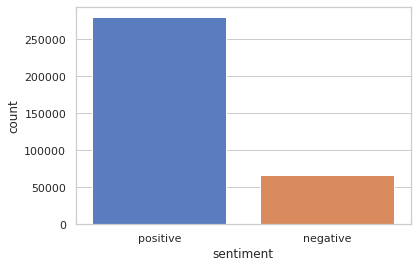

In [304]:
sns.countplot(mcAuley.sentiment)

### Reading scraped data

In [8]:
products = pd.read_pickle("reviews.pkl")
products_t = products.T
products_t.index.name = "product_id"
reviews = pd.DataFrame()
reviews_rating  = []
reviews_text = []
reviews_productname = []
reviews_product = []
for ind, row in products_t.iterrows():
    for rev in row['reviews'][0:len(row['reviews'])]:
        reviews_rating.append(rev['rating'])
        reviews_text.append(rev['text'])
        reviews_productname.append(row['name'])
        reviews_product.append(ind)
reviews = pd.DataFrame({'rating':reviews_rating, 'text':reviews_text, 'product_name':reviews_productname, 'product':reviews_product})

In [308]:
reviews.head()

,rating,text,product_name,product
0,1.0,I work for NOW Foods and bought three differen...,"PhosphatidylSerine 300mg Per Serving, Made in ...",B079YF1K1B
1,5.0,You can't beat $19.95 for PS with 120 caps! Ye...,"PhosphatidylSerine 300mg Per Serving, Made in ...",B079YF1K1B
2,5.0,I was waking up at 4:00 a.m each morning due t...,"PhosphatidylSerine 300mg Per Serving, Made in ...",B079YF1K1B
3,5.0,I'm 47 I have been in flight and survive mode ...,"PhosphatidylSerine 300mg Per Serving, Made in ...",B079YF1K1B
4,5.0,I've been taking phosphatidylserine for a whil...,"PhosphatidylSerine 300mg Per Serving, Made in ...",B079YF1K1B


In [9]:
reviews = reviews.dropna()

In [10]:
reviews['rating'] = reviews['rating'].astype(int)

In [11]:
reviews['sentiment'] = reviews.rating.apply(sentiment_level)


In [313]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19261 entries, 0 to 19674
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   rating        19261 non-null  int64 
 1   text          19261 non-null  object
 2   product_name  19261 non-null  object
 3   product       19261 non-null  object
 4   sentiment     19261 non-null  object
dtypes: int64(1), object(4)
memory usage: 902.9+ KB


###Splitting datasets and fixing unbalanced data

In [ ]:
#in case you want to use the scraped data as both train and test sets:
  # train, test = train_test_split(reviews, test_size=0.33, random_state=30)

In [12]:
sqlCtx = SQLContext(spark)

In [13]:
spark_train = sqlCtx.createDataFrame(mcAuley)
spark_test = sqlCtx.createDataFrame(reviews)

In [14]:
spark_train_pos = spark_train.filter(F.col('sentiment') == "positive")
spark_train_neg = spark_train.filter(F.col('sentiment') == 'negative')
# spark_train_neu = spark_train.filter(F.col('sentiment') == 'neutral')

In [15]:
pnratio = int(spark_train_pos.count()/spark_train_neg.count())
print("ratio: {}".format(pnratio))

ratio: 4


In [16]:
undersampled_pos = spark_train_pos.sample(False, 1/pnratio)
spark_train = undersampled_pos.unionAll(spark_train_neg)

In [17]:
pd_train = spark_train.toPandas()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


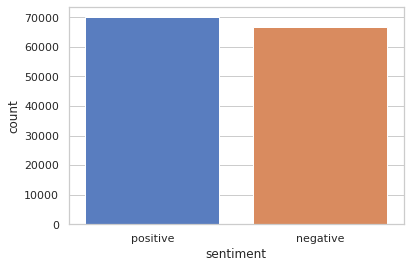

In [18]:
sns.countplot(pd_train['sentiment'])

In [19]:
spark_train_pos = spark_train.filter(F.col('sentiment') == "positive")
spark_train_neu = spark_train.filter(F.col('sentiment') == 'negative')
fixed_psratio = int(spark_train_pos.count()/spark_train_neg.count())
print("ratio: {}".format(fixed_psratio))

ratio: 1


In [ ]:
# pnratio = int(spark_train_pos.count()/spark_train_neu.count())
# print("ratio: {}".format(pnratio))

ratio: 1


### Defining Spark Pipeline 

In [20]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")
    
use = UniversalSentenceEncoder.pretrained(name="tfhub_use", lang="en")\
 .setInputCols(["document"])\
 .setOutputCol("sentence_embeddings")\

classifier_dl = ClassifierDLApproach()\
  .setInputCols(["sentence_embeddings"])\
  .setOutputCol("class")\
  .setLabelColumn("sentiment")\
  .setLr(0.001)\
  .setBatchSize(8)\
  .setMaxEpochs(3)\

sentimentdl = SentimentDLApproach()\
  .setInputCols(["sentence_embeddings"])\
  .setOutputCol("class")\
  .setLabelColumn("sentiment")\
  .setMaxEpochs(5)\
  .setEnableOutputLogs(True)

multi_classifierdl = MultiClassifierDLApproach()\
      .setInputCols("sentence_embeddings")\
      .setOutputCol("class")\
      .setLabelColumn("sentiment")\
      .setBatchSize(128)\
      .setMaxEpochs(5)\
      .setLr(1e-3)\
      .setThreshold(0.5)\
      .setShufflePerEpoch(False)\
      .setEnableOutputLogs(True)\
      .setValidationSplit(0.1)

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]


In [21]:
gs_pipeline = Pipeline(stages=[
          documentAssembler, 
          use,
          classifier_dl
 ])


### Using pipeline to create & use model

In [22]:
gs_pipeline_model = gs_pipeline.fit(spark_train)


In [23]:
preds = gs_pipeline_model.transform(spark_test)

In [24]:
preds.select('sentiment', 'rating', 'text', 'class.result').show(300, truncate=100)

+---------+------+----------------------------------------------------------------------------------------------------+----------+
|sentiment|rating|                                                                                                text|    result|
+---------+------+----------------------------------------------------------------------------------------------------+----------+
| negative|     1|I work for NOW Foods and bought three different bottles of this product, lot # 1912697.  We teste...|[positive]|
| positive|     5|You can't beat $19.95 for PS with 120 caps! Yes, I do have to take a bit more for the same effect...|[negative]|
| positive|     5|I was waking up at 4:00 a.m each morning due to cortisol spikes and would be wired and tired all ...|[positive]|
| positive|     5|I'm 47 I have been in flight and survive mode for 45 yrs with HIGH cortisone levels until I devel...|[positive]|
| positive|     5|I've been taking phosphatidylserine for a while now.  I'm still f

In [44]:
result_df = preds.select('sentiment', 'product', 'product_name', 'text', 'class.result').toPandas()

In [45]:
result_df = result_df.drop(result_df[result_df["result"].str.len() == 0].index)

In [64]:
result_df['result'] = result_df['result'].apply(lambda x: x[0])
print(classification_report(result_df['sentiment'], result_df['result']))
print("accuracy score: ", accuracy_score(result_df['sentiment'], result_df['result']))

              precision    recall  f1-score   support

    negative       0.41      0.78      0.54      2316
    positive       0.97      0.85      0.90     16942

    accuracy                           0.84     19258
   macro avg       0.69      0.82      0.72     19258
weighted avg       0.90      0.84      0.86     19258

accuracy score:  0.8406895835496936


In [28]:
print(confusion_matrix(result_df['sentiment'], result_df['result']))

[[ 1818   498]
 [ 2570 14372]]


###Organizing result data

In [70]:
result_df.set_index('product')

,sentiment,product_name,text,result
product,,,,
B079YF1K1B,negative,"PhosphatidylSerine 300mg Per Serving, Made in ...",I work for NOW Foods and bought three differen...,positive
B079YF1K1B,positive,"PhosphatidylSerine 300mg Per Serving, Made in ...",You can't beat $19.95 for PS with 120 caps! Ye...,negative
B079YF1K1B,positive,"PhosphatidylSerine 300mg Per Serving, Made in ...",I was waking up at 4:00 a.m each morning due t...,positive
B079YF1K1B,positive,"PhosphatidylSerine 300mg Per Serving, Made in ...",I'm 47 I have been in flight and survive mode ...,positive
B079YF1K1B,positive,"PhosphatidylSerine 300mg Per Serving, Made in ...",I've been taking phosphatidylserine for a whil...,positive
...,...,...,...,...
B0183BYQW0,negative,BoostCeuticals Nattokinase 100 200 mg Vegan No...,Price and shipping was great but I Quality to...,negative
B0183BYQW0,positive,BoostCeuticals Nattokinase 100 200 mg Vegan No...,very beneficial,positive
B0183BYQW0,positive,BoostCeuticals Nattokinase 100 200 mg Vegan No...,great product,positive


In [71]:
results_df_prod = result_df.drop(columns={'sentiment'})

In [72]:
results_df_prod = results_df_prod.drop_duplicates()

In [73]:
new_df = pd.DataFrame()
new_df['product'] = results_df_prod['product'].unique()

product_df = pd.DataFrame(columns=["product", "product name" "text", "total", "pos_count"])
product_df.set_index('product')

for product in new_df['product']:
  reviews = results_df_prod.loc[results_df_prod['product'] == product]
  text = []
  product_name = ""
  pos_count = 0
  total = 0 
  for productn in reviews['product_name']:
    product_name = productn
  for review_text in reviews['text']:
    text.append(review_text)
  for res in reviews['result']:
    total += 1
    if res == "positive":
      pos_count += 1
  to_append = pd.DataFrame([[product, product_name, text, total, pos_count]], columns=["product", "product_name", "text", "total", "pos_count"])
  to_append.set_index('product')
  product_df = product_df.append(to_append, ignore_index=True)

In [74]:
product_df['%positive'] = (product_df['pos_count'] / product_df['total']) * 100 

In [75]:
final_df = product_df.sort_values('total', 0, ascending=False).head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_values except for the argument 'by' will be keyword-only
  """Entry point for launching an IPython kernel.


In [102]:
final_df = final_df.sort_values('%positive', ascending=False)

In [103]:
final_df

,product,total,pos_count,product_name,text,%positive
38,B07PFYH2PQ,350,295,"Phosphatidylcholine 1,200mg – 210 Softgels – E...",[I believe Double Wood makes good quality supp...,84.285714
2,B08LF5G6J1,349,288,Ultra High Purity Phosphatidylserine from Ital...,[Partner and I are on our second bottle and we...,82.52149
30,B07WWB12VT,4863,3991,ONNIT Alpha Brain (180ct) - Premium Nootropic ...,[This product needs be thrown in the boxing ri...,82.068682
0,B079YF1K1B,1097,896,"PhosphatidylSerine 300mg Per Serving, Made in ...",[I work for NOW Foods and bought three differe...,81.677302
45,B00S1XUS1Y,3222,2601,"LES Labs Cortisol Health, Adrenal Support Supp...","[I have been to the cardiologist, PCP, and in ...",80.726257
51,B072JG37CY,611,473,"Havasu Nutrition Ginkgo Biloba Non-GMO 120mg, ...",[I have tried many supplements over the years....,77.414075
60,B0739KKHWL,4061,2975,"Nordic Naturals Ultimate Omega, Lemon Flavor -...",[I know it is a little more pricey but in our ...,73.257818
4,B0013OXA90,280,203,Jarrow Formulas PS 100-60 Softgels - 100 mg Ph...,[I'm so impressed with this supplement. It has...,72.5
23,B086CJD8L2,397,197,Neuriva Nootropic Brain Support Supplement - O...,[The product is fantastic IMO...within 2 weeks...,49.622166
44,B07Z6VFMM4,338,165,Neuriva Nootropic Brain Support Supplement - O...,[There are not enough vitiamns or minerals to ...,48.816568


In [104]:
##Copying preprocessing functions used earlier in our project
def preprocessString(text):
    text = text.lower()

    # Remove Urls
    urls = re.compile(re.compile(r'(https?:\/\/[www\.]?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-z]{2,6}\b[-a-zA-Z0-9@:%_\+.~#?&//=]*)'))
    text = re.sub(urls, '', text)

    # Remove Hashtags
    hashtags = re.compile(r'\B#\w*[a-zA-Z]+\w*')
    text = re.sub(hashtags, '',text)

    # Remove @ signs
    atSigns = re.compile(r'\B@\w*[a-z0-9]+\w*')
    text = re.sub(atSigns, '', text)

    # Remove Emojis
    emojis = re.compile(r'[\U00010000-\U0010ffff]', flags=re.UNICODE)
    text = re.sub(emojis, '', text)

    # Remove Punctuations
    punctuations = re.compile(r'\W+')
    text = re.sub(punctuations, ' ', text)
    
    # Remove Digits
    text = re.sub(r'\d+', '', text)

    # Tokenize the text
    token = nltk.word_tokenize(text)

    # Remove stopwords
    stopWords = set(nltk.corpus.stopwords.words('english'))
    filteredToken = []
    for t in token:
      if t not in stopWords:
        filteredToken.append(t)


    # Lemmatize the review and return the list to preprocessList
    lemmatize = [WordNetLemmatizer().lemmatize(x) for x in filteredToken]
    lemmatize = [x for x in lemmatize if x not in['rt','http'] and len(x)>1]
    return lemmatize

In [105]:
def preprocessList(lst):
  processedList = []
  if lst:
    for i in range(len(lst)):
      if lst[i]:
        processedList.append(preprocessString(lst[i]))
    if preprocessList:
      return processedList
    else:
      return None

In [120]:
#copied and modified code from the topic modling portion of our project
#currently unused, use if topic modeling results is disired

# def find_topics(lstlst):
#   result = []
#   lst = list(lstlst)
#   arr_flat = []
#   for e1 in lstlst:
#       if e1:
#         for e2 in e1:
#           if e2:
#             arr_flat.append(e2)
#   dictionary = gensim.corpora.Dictionary([arr_flat])
#   bow_corpus = [dictionary.doc2bow(doc) for doc in [arr_flat]]
#   tfidf = models.TfidfModel(bow_corpus)
#   corpus_tfidf = tfidf[bow_corpus]
#   lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=2, id2word=dictionary, passes=2, workers=2)
  #if num_topics > 1 use the following
  # topic_words = []
  # for topic in range(10):
  #   topic_words.append(re.findall(r'[a-z]+', lda_model.show_topics()[0][1]))
  # return topic_words
  return re.findall(r'[a-z]+', lda_model.show_topics()[0][1])

In [172]:
counter = collections.Counter()
def most_common(lstlst):
  result = []
  lst = list(lstlst)
  arr_flat = []
  for e1 in lstlst:
      if e1:
        for e2 in e1:
          if e2:
            arr_flat.append(e2)
  counter.update(arr_flat)
  words = []
  for w in counter.most_common(10):
    words.append(w[0])
  return words

In [121]:
top_prod_df = final_df.head(3)
bottom_prod_df = final_df.tail(3)

In [ ]:
top_prod_df['product_name']

In [ ]:
top_prod_df['processed_rev'] = top_prod_df['text'].apply(preprocessList)

In [ ]:
top_prod_df['common_words'] = top_prod_df['processed_rev'].apply(most_common)

In [ ]:
top_prod_df['common_words']

In [182]:
top_prod_words = [word for word in top_prod_df['common_words']]

In [ ]:
top_prod_words

In [ ]:
top_prod_df.plot.barh('product_name', '%positive', fontsize=16)

In [ ]:
bottom_prod_df['processed_rev'] = bottom_prod_df['text'].apply(preprocessList)

In [ ]:
bottom_prod_df

In [ ]:
bottom_prod_df['common_words'] = bottom_prod_df['processed_rev'].apply(most_common)

In [ ]:
bottom_prod_df

In [180]:
bottom_prod_words = [word for word in bottom_prod_df['common_words']]

In [ ]:
bottom_prod_words

In [ ]:
bottom_prod_df.plot.barh('product_name', '%positive')